# 1. Setup and Connection

In [ ]:
# Importing important libraries.
# One may need to install CherryPy, fitbit, xlvt, xlwt, openpyxl and the below mentioned libraries.
# gather_keys_oauth2.py is located in the fitbit package installed.
# Make sure it is in the same directory as your notebook.

%matplotlib inline
import matplotlib.pyplot as plt
import fitbit
import gather_keys_oauth2 as Oauth2
import pandas as pd 
import datetime
import numpy as np
from datetime import timedelta

In [19]:
# App Credentials
CLIENT_ID='22BN2X'
CLIENT_SECRET='d65e1e17d06b5488dc992463341b2d59'

# Authorization pipeline
# Make sure that the callback URL('http://127.0.0.1:8080/') of your app is same 
# as the one mentioned in __init__() function of gather_keys_oauth2.py file. 
# Change as per your needs.
server=Oauth2.OAuth2Server(CLIENT_ID, CLIENT_SECRET)
server.browser_authorize()
ACCESS_TOKEN=str(server.fitbit.client.session.token['access_token'])
REFRESH_TOKEN=str(server.fitbit.client.session.token['refresh_token'])
auth2_client=fitbit.Fitbit(CLIENT_ID,CLIENT_SECRET,oauth2=True,access_token=ACCESS_TOKEN,refresh_token=REFRESH_TOKEN)

[17/Jun/2020:12:51:48] ENGINE Listening for SIGTERM.
[17/Jun/2020:12:51:48] ENGINE Listening for SIGHUP.
[17/Jun/2020:12:51:48] ENGINE Listening for SIGUSR1.
[17/Jun/2020:12:51:48] ENGINE Bus STARTING
CherryPy Checker:
The Application mounted at '' has an empty config.

[17/Jun/2020:12:51:48] ENGINE Started monitor thread 'Autoreloader'.
[17/Jun/2020:12:51:48] ENGINE Serving on http://127.0.0.1:8080
[17/Jun/2020:12:51:48] ENGINE Bus STARTED


127.0.0.1 - - [17/Jun/2020:12:51:52] "GET /?code=b9538be42533f2f34555ad63dc0829b29eb793a1&state=JWaUXk8cjp1i9cBKcd8M5XO9pVMyaK HTTP/1.1" 200 122 "" "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:77.0) Gecko/20100101 Firefox/77.0"
127.0.0.1 - - [17/Jun/2020:12:51:52] "GET /favicon.ico HTTP/1.1" 200 1406 "" "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:77.0) Gecko/20100101 Firefox/77.0"


[17/Jun/2020:12:51:53] ENGINE Bus STOPPING
[17/Jun/2020:12:51:53] ENGINE HTTP Server cherrypy._cpwsgi_server.CPWSGIServer(('127.0.0.1', 8080)) shut down
[17/Jun/2020:12:51:53] ENGINE Stopped thread 'Autoreloader'.
[17/Jun/2020:12:51:53] ENGINE Bus STOPPED
[17/Jun/2020:12:51:53] ENGINE Bus EXITING
[17/Jun/2020:12:51:53] ENGINE Bus EXITED
[17/Jun/2020:12:51:53] ENGINE Waiting for child threads to terminate...


# 2. Collection of Heart Data

In [85]:
# This format is required for API calls
DATE_FORMAT = '%Y-%m-%d'

# Utility functions
def connectAndLoadDb():
    print("Connecting database...")
    database = pd.read_excel(databaseFilename)
    print("Database connected!")
    return database;

def getLastEntryDate(database):
    lastDateEntry = database.iloc[-1]['Date']
    lastDateEntry = datetime.datetime.strptime(lastDateEntry, DATE_FORMAT)    
    return lastDateEntry

def addEntriesInDB(dictionary, database):
    #print(dictionary)
    database = database.append(dictionary, ignore_index=True)
    return database;

def writeDbToExcelFile(database):
    print('Writing database to filename: '+ databaseFilename)
    writer = pd.ExcelWriter(databaseFilename)
    database.to_excel(writer, 'main')
    writer.save()
    print('Database updated with new entries!!')
    
def prettyPrintDate(date):
    return date.strftime(DATE_FORMAT);

In [13]:
# API call to get heart data by seconds
def getHeartData(date):
    df_list = []
    date_list = []
    dateStr = prettyPrintDate(date)
    oneDayData = auth2_client.intraday_time_series('activities/heart', base_date=dateStr, detail_level='1sec')
    df = pd.DataFrame(oneDayData['activities-heart-intraday']['dataset'])
    weekDayNum = date.isoweekday()
    if len(df):
        df.loc[:, 'Date'] = dateStr
        df.loc[:, 'Day of Week'] = weekDayNum
        df.loc[:, 'Is Weekday'] = weekDayNum < 6
        df.loc[:, 'Is Weekend'] = weekDayNum > 5

    return df

In [14]:
def fetchAllData(date):
    dateStr = prettyPrintDate(date)
    print("Fetching fitbit data for: " + dateStr) 
    heartandDateData = getHeartData(date)
    return heartandDateData

def shouldFetchDataForProvidedDate(providedDate, todaysDate, API_COUNTER):
    return (providedDate < todaysDate) and API_COUNTER < 100;

def fetchAndAppendToDb(date, database):    
    mergedData = fetchAllData(date)
    database = database.append(mergedData, ignore_index=True)
    return database;

def fetchData(database, refetchAll = False):
    API_COUNTER = 0
    df_list = []
    date_list = []
    todaysDate = datetime.datetime.today()
    
    print("Date today is :" + prettyPrintDate(todaysDate))
    
    if refetchAll == True:
        lastEntryDate = datetime.datetime.strptime('2020-04-10', DATE_FORMAT)
    else:
        lastEntryDate = getLastEntryDate(database)
    
    print("Last entry in Db is of :" + prettyPrintDate(lastEntryDate))
    print("----------------------------------------------")
    
    dateToFetch = lastEntryDate + timedelta(days=1)
    while shouldFetchDataForProvidedDate(dateToFetch, todaysDate, API_COUNTER):    
        database = fetchAndAppendToDb(dateToFetch, database)
        dateToFetch = dateToFetch + timedelta(days=1)
        API_COUNTER = API_COUNTER+1
    
    print("----------------------------------------------")
    print("Data fill completed! 👍👍")
    return database

In [ ]:
# database = fetchData(database, True)

In [ ]:
# databaseFilename = 'data/database_micro.xlsx'
# writeDbToExcelFile(database)

# 3. Add Time to Date Data

In [87]:
database = connectAndLoadDb()
database = database.loc[:, ~database.columns.str.contains('^Unnamed')]

Connecting database...
Database connected!


In [47]:
final_df = database.copy()
hoursDelta = pd.to_datetime(final_df.loc[:, 'time']).dt.hour.apply(lambda x: datetime.timedelta(hours = x))
minutesDelta = pd.to_datetime(final_df.loc[:, 'time']).dt.minute.apply(lambda x: datetime.timedelta(minutes = x))
secondsDelta = pd.to_datetime(final_df.loc[:, 'time']).dt.second.apply(lambda x: datetime.timedelta(seconds = x))

In [48]:
final_df['Date'] = final_df['Date'] + hoursDelta + minutesDelta + secondsDelta

In [50]:
databaseFilename = 'data/database_microdHMS.xlsx'
writeDbToExcelFile(final_df)

Writing database to filename: data/database_microdHMS.xlsx
Database updated with new entries!!


In [86]:
database.head()

,time,value,Date,Day of Week,Is Weekday,Is Weekend
0,00:00:04,80,2020-04-11,6,False,True
1,00:00:09,79,2020-04-11,6,False,True
2,00:00:14,78,2020-04-11,6,False,True
3,00:00:29,80,2020-04-11,6,False,True
4,00:00:34,81,2020-04-11,6,False,True


In [58]:
final_df['HourMinute'] = final_df['time'].str.slice(start=0, stop=5)
final_df['Hour'] = final_df['time'].str.slice(start=0, stop=2)

In [88]:
final_df.head()

,time,value,Date,Day of Week,Is Weekday,Is Weekend,HourMinute,Hour
0,00:00:04,80,2020-04-11 00:00:04,6,False,True,00:00,0
1,00:00:09,79,2020-04-11 00:00:09,6,False,True,00:00,0
2,00:00:14,78,2020-04-11 00:00:14,6,False,True,00:00,0
3,00:00:29,80,2020-04-11 00:00:29,6,False,True,00:00,0
4,00:00:34,81,2020-04-11 00:00:34,6,False,True,00:00,0


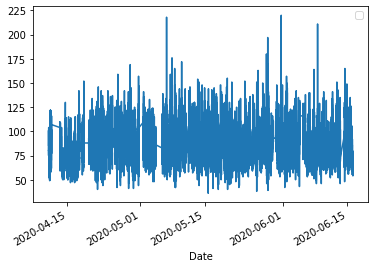

In [180]:
# this fixed the problem.
final_df.plot('Date', 'value')
plt.legend('')

In [89]:
## Looking at a couple days only. 
startDate = datetime.datetime(year = 2020, month = 5, day = 15)
lastDate = datetime.datetime(year = 2020, month = 5, day = 27)

coupledays_df = final_df.loc[database.loc[:, 'Date'].between(startDate, lastDate), :]

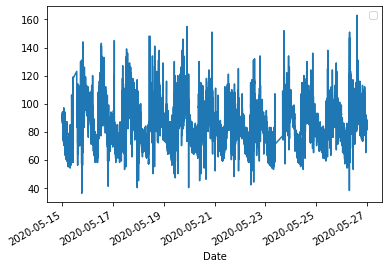

In [90]:
coupledays_df.plot('Date', 'value')
plt.legend('')

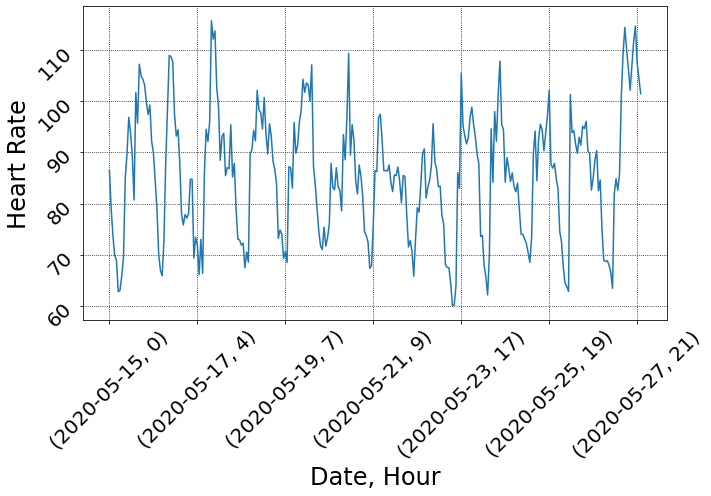

In [187]:
fig, ax = plt.subplots(figsize=(10, 7))

times = pd.to_datetime(coupledays_df['Date'])
coupledays_df.groupby([times.dt.date,times.dt.hour]).value.mean().plot(ax = ax)

ax.grid(True,
    axis = 'both',
    zorder = 0,
    linestyle = ':',
    color = 'k')
ax.tick_params(axis = 'both', rotation = 45, labelsize = 20)
ax.set_xlabel('Date, Hour', fontsize = 24)
ax.set_ylabel('Heart Rate', fontsize = 24)
fig.tight_layout()
fig.savefig('coupledaysavergedByMin.png', format = 'png', dpi = 300)

# 4. Collect resting Heart Rate

In [30]:
def fetchAllData(date):
    dateStr = prettyPrintDate(date)
    print("Fetching fitbit data for: " + dateStr) 
    oneDayData = auth2_client.intraday_time_series('activities/heart', base_date=dateStr, detail_level='1sec')
    return oneDayData

def shouldFetchDataForProvidedDate(providedDate, todaysDate, API_COUNTER):
    return (providedDate < todaysDate) and API_COUNTER < 100;

def fetchAndAppend(date):    
    oneDayData = fetchAllData(date)
    dateStr = prettyPrintDate(date)
    if 'restingHeartRate' in oneDayData['activities-heart'][0]['value'].keys():
        resting_list.append(oneDayData['activities-heart'][0]['value']['restingHeartRate'])
        date_list.append(dateStr)

def fetchRestingData(refetchAll = False):
    API_COUNTER = 0
    df_list = []
    date_list = []
    todaysDate = datetime.datetime.today()
    
    print("Date today is :" + prettyPrintDate(todaysDate))
    
    if refetchAll == True:
        lastEntryDate = datetime.datetime.strptime('2020-04-10', DATE_FORMAT)
    else:
        lastEntryDate = date_list[-1]
    
    print("Last entry in Db is of :" + prettyPrintDate(lastEntryDate))
    print("----------------------------------------------")
    
    dateToFetch = lastEntryDate + timedelta(days=1)
    while shouldFetchDataForProvidedDate(dateToFetch, todaysDate, API_COUNTER):    
        fetchAndAppend(dateToFetch)
        dateToFetch = dateToFetch + timedelta(days=1)
        API_COUNTER = API_COUNTER+1
    
    print("----------------------------------------------")
    print("Data fill completed! 👍👍")

In [36]:
# date_list = []
# resting_list = []
# DATE_FORMAT = '%Y-%m-%d'
# databaseFilename = 'data/database_microRHR.xlsx'

In [37]:
# fetchRestingData(refetchAll = True)

Date today is :2020-06-17
Last entry in Db is of :2020-04-10
----------------------------------------------
Fetching fitbit data for: 2020-04-11
Fetching fitbit data for: 2020-04-12
Fetching fitbit data for: 2020-04-13
Fetching fitbit data for: 2020-04-14
Fetching fitbit data for: 2020-04-15
Fetching fitbit data for: 2020-04-16
Fetching fitbit data for: 2020-04-17
Fetching fitbit data for: 2020-04-18
Fetching fitbit data for: 2020-04-19
Fetching fitbit data for: 2020-04-20
Fetching fitbit data for: 2020-04-21
Fetching fitbit data for: 2020-04-22
Fetching fitbit data for: 2020-04-23
Fetching fitbit data for: 2020-04-24
Fetching fitbit data for: 2020-04-25
Fetching fitbit data for: 2020-04-26
Fetching fitbit data for: 2020-04-27
Fetching fitbit data for: 2020-04-28
Fetching fitbit data for: 2020-04-29
Fetching fitbit data for: 2020-04-30
Fetching fitbit data for: 2020-05-01
Fetching fitbit data for: 2020-05-02
Fetching fitbit data for: 2020-05-03
Fetching fitbit data for: 2020-05-04
Fetc

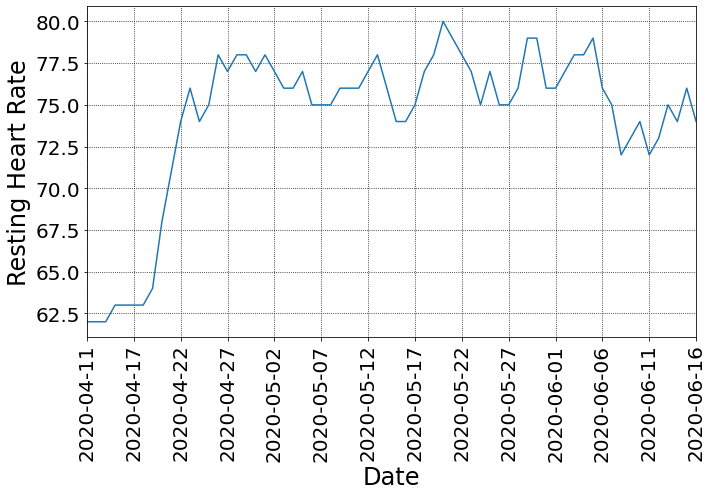

In [38]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(date_list, resting_list )

# This is just making it so there isnt a grid line or text for every point
xtick_list = []
xticklabel_list = []
for index, label in enumerate(ax.get_xticklabels()):
    if index % 5 == 0:
        xticklabel_list.append(label)
        xtick_list.append(index)

ax.grid(True,
    axis = 'both',
    zorder = 0,
    linestyle = ':',
    color = 'k')
ax.tick_params(axis = 'both', labelsize = 20)
ax.set_xticks(xtick_list)
ax.tick_params(axis = 'x', rotation = 90,labelsize = 20)
ax.set_xlim(0, index)
#ax.set_xticklabels(ax.get_xticklabels(),rotation = 45, rotation_mode="anchor", ha = 'right')
ax.set_xlabel('Date', fontsize = 24)
ax.set_ylabel('Resting Heart Rate', fontsize = 24)
fig.tight_layout()
fig.savefig('restingHR_graph.png', format = 'png', dpi = 300)


In [39]:
resting_df = pd.DataFrame({'date': date_list, 'RHR': resting_list})
resting_df.head()

,date,RHR
0,2020-04-11,62
1,2020-04-13,62
2,2020-04-14,62
3,2020-04-15,63
4,2020-04-16,63


In [40]:
writeDbToExcelFile(resting_df)

Writing database to filename: data/database_microRHR.xlsx
Database updated with new entries!!


# 5. Analysis of Heart Data

In [41]:
def summary_stat(df, col_name): #function to provide median, min, and max of data
    df = pd.DataFrame({'Mean ' : str(round(np.mean(df[col_name]),2)),
         'Median' : str(np.median(df[col_name])),
         'Min' : str(np.min(df[col_name])),
         'Max' : str(np.max(df[col_name]))}, index=[0])
    return df

In [52]:
summary_stat(final_df, 'value')

,Mean,Median,Min,Max
0,83.9,84.0,36,220


A bit of a right skew. But seems pretty close.

/home/abdulkk49/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


Text(50, -3000, 'By Abdul')

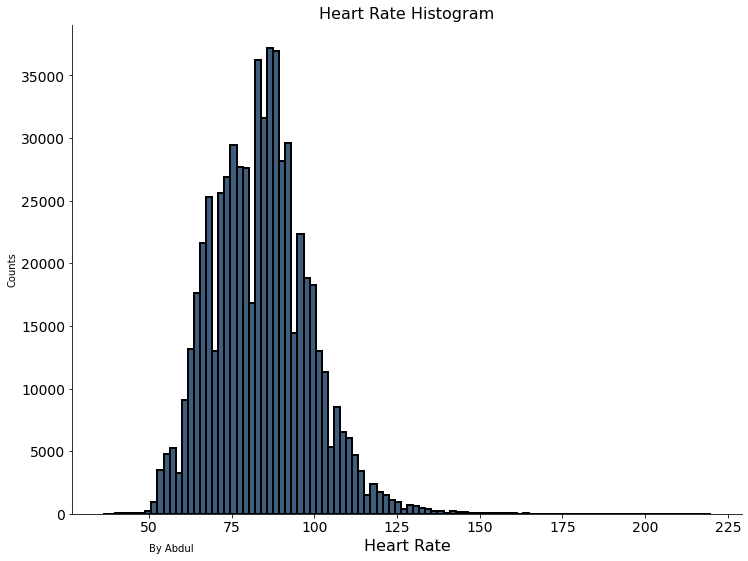

In [56]:
HR = final_df['value']
plt.figure(figsize=(12, 9)) 
plt.hist(HR, range=(np.min(HR),np.max(HR)),
         linewidth=2,color="#3F5D7D", bins=100,edgecolor='black')

ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.title('Heart Rate Histogram', fontsize=16)
plt.xlabel('Heart Rate', fontsize=16)
plt.ylabel('Counts')

plt.text(50,-3000, "By Abdul",
         fontsize=10)

In [59]:
final_df.head()

,time,value,Date,Day of Week,Is Weekday,Is Weekend,HourMinute,Hour
0,00:00:04,80,2020-04-11 00:00:04,6,False,True,00:00,00
1,00:00:09,79,2020-04-11 00:00:09,6,False,True,00:00,00
2,00:00:14,78,2020-04-11 00:00:14,6,False,True,00:00,00
3,00:00:29,80,2020-04-11 00:00:29,6,False,True,00:00,00
4,00:00:34,81,2020-04-11 00:00:34,6,False,True,00:00,00


In [62]:
Hourlydf = final_df.groupby(by='Hour').mean()
Hourlydf

,value,Day of Week,Is Weekday,Is Weekend
Hour,,,,
00,83.224693,3.809129,0.753308,0.246692
01,79.996643,3.834664,0.751770,0.248230
02,76.431451,3.835547,0.744612,0.255388
03,73.508571,3.803566,0.756832,0.243168
04,71.064798,3.793712,0.757840,0.242160
05,69.516867,3.805116,0.758793,0.241207
06,68.762541,3.821905,0.759212,0.240788
07,68.950937,3.789403,0.756589,0.243411
08,72.739450,3.879019,0.735021,0.264979


Text(0, 0.5, 'Heart Rate')

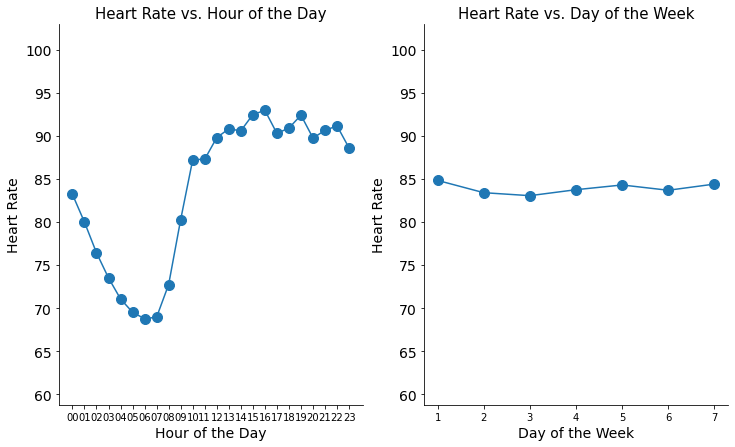

In [68]:
dayCodes = ['', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fig = plt.figure(figsize = (12,7))

ax = plt.subplot(121)  
Hourlydf = final_df.groupby(by='Hour').mean()
meanHeart = Hourlydf['value']

plt.plot(meanHeart, linestyle='-', marker='o', markersize=10)

ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()
ax.set_ylim([np.min(meanHeart)-10, np.max(meanHeart)+10])
plt.xticks(fontsize=10)  
plt.yticks(fontsize=14)  

plt.title('Heart Rate vs. Hour of the Day', fontsize=15)
plt.xlabel(meanHeart.index.name)
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Heart Rate', fontsize=14)

#############

ax2 = fig.add_subplot(122)
DOWdf = final_df.groupby(by='Day of Week').mean()
meanDOW = DOWdf['value']
meanDOW.plot(linestyle='-', marker='o', markersize=10)
  
ax2.spines["top"].set_visible(False)  
ax2.spines["right"].set_visible(False)  

ax2.get_xaxis().tick_bottom()  
ax2.get_yaxis().tick_left()
ax2.set_ylim([np.min(meanHeart)-10, np.max(meanHeart)+10])

plt.xticks(fontsize=10)  
plt.yticks(fontsize=14)  

plt.title('Heart Rate vs. Day of the Week', fontsize=15)
plt.xlabel(meanDOW.index.name, fontsize=14)
plt.xlabel('Day of the Week')
plt.ylabel('Heart Rate', fontsize=14)

The drop in heart rate in between 01 to 07 indicates sleeping hours. Day of the week doesn't show much difference on average. 

In [73]:
final_df['Hour'] = final_df['Hour'].astype(int)
Nine_to_fivedf = final_df[(final_df['Hour'] >= 8) & (final_df['Hour'] <= 18) & (final_df['Day of Week'] != 6) & (final_df['Day of Week'] != 7)] 
Free_timedf = final_df[~((final_df['Hour'] >= 8) & (final_df['Hour'] <= 18) & (final_df['Day of Week'] != 6) & (final_df['Day of Week'] != 7))]

In [79]:
Nine_to_fivedf

,time,value,Date,Day of Week,Is Weekday,Is Weekend,HourMinute,Hour
7416,11:02:33,104,2020-04-13 11:02:33,1,True,False,11:02,11
7417,11:02:38,90,2020-04-13 11:02:38,1,True,False,11:02,11
7418,11:02:43,77,2020-04-13 11:02:43,1,True,False,11:02,11
7419,11:02:48,109,2020-04-13 11:02:48,1,True,False,11:02,11
7420,11:02:53,93,2020-04-13 11:02:53,1,True,False,11:02,11
...,...,...,...,...,...,...,...,...
615780,18:59:25,95,2020-06-16 18:59:25,2,True,False,18:59,18
615781,18:59:35,94,2020-06-16 18:59:35,2,True,False,18:59,18
615782,18:59:40,93,2020-06-16 18:59:40,2,True,False,18:59,18
615783,18:59:45,92,2020-06-16 18:59:45,2,True,False,18:59,18


In [75]:
Free_timedf

,time,value,Date,Day of Week,Is Weekday,Is Weekend,HourMinute,Hour
0,00:00:04,80,2020-04-11 00:00:04,6,False,True,00:00,0
1,00:00:09,79,2020-04-11 00:00:09,6,False,True,00:00,0
2,00:00:14,78,2020-04-11 00:00:14,6,False,True,00:00,0
3,00:00:29,80,2020-04-11 00:00:29,6,False,True,00:00,0
4,00:00:34,81,2020-04-11 00:00:34,6,False,True,00:00,0
...,...,...,...,...,...,...,...,...
618018,23:48:37,78,2020-06-16 23:48:37,2,True,False,23:48,23
618019,23:48:42,76,2020-06-16 23:48:42,2,True,False,23:48,23
618020,23:48:47,76,2020-06-16 23:48:47,2,True,False,23:48,23
618021,23:48:52,77,2020-06-16 23:48:52,2,True,False,23:48,23


In [ ]:
print('HR when Awake: '+str(round(Nine_to_fivedf['value'].mean(),2)))
print('HR when Awake: '+str(round(Free_timedf['value'].mean(),2)))

In [83]:
Free_time_wokedf = Free_timedf[(Free_timedf['Hour']>=17)|(Free_timedf['Hour']<=1)]
Free_time_sleepdf = Free_timedf[~(Free_timedf['Hour']>=17)|(Free_timedf['Hour']<=1)]
print('HR when Free & Awake: '+str(round(Free_time_wokedf['value'].mean(),2)))
print('HR when Free & Asleep: '+str(round(Free_time_sleepdf['value'].mean(),2)))

HR when Free & Awake: 88.13
HR when Free & Asleep: 77.04


/home/abdulkk49/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


Text(0.5, 0, 'Day of the Week')

<Figure size 864x504 with 0 Axes>

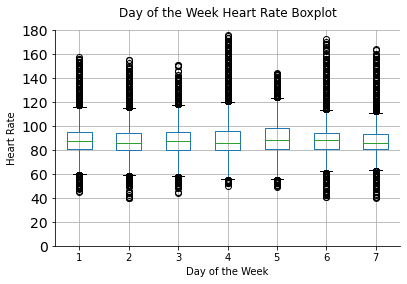

In [91]:
fig = plt.figure(figsize = (12,7))
Free_time_wokedf.boxplot(column = 'value', by = 'Day of Week')

ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.set_ylim([0, 180])
plt.xticks(fontsize=10)  
plt.yticks(fontsize=14) 

plt.title('')
plt.suptitle('Day of the Week Heart Rate Boxplot')
plt.ylabel('Heart Rate')
plt.xlabel('Day of the Week')

Further recommendations:
We can use machine learning models to fill in the missing values.
Also, further analyses could have been drawn if sleeping patterns, work hours of someone are known before hand.